imports

In [1]:
import torch
import os
from tqdm.notebook import tqdm as tqdm
import pandas as pd
import json
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import hashlib

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train.configParser import getModelName, ConfigParser
from HGNN.train import CNN

config_plots.global_settings()

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"

experiment_list = [
#     {
#        'experimentName': "biology_paper_hard_HGNN_constant_lambda",
#        'experimentHash': None
#     },
#     {
#        'experimentName': "biology_paper_hard_HGNN_adaptive_lambda",
#        'experimentHash': None
#     },
#     {
#        'experimentName': "biology_paper_hard_BB",
#        'experimentHash': None
#     },
#     {
#        'experimentName': "biology_paper_medium_HGNN_constant_lambda",
#        'experimentHash': None
#     },
#     {
#        'experimentName': "biology_paper_easy_curated3_50_30",
#        'experimentHash': ['0e4047f9cdcfde1594d90ba13febd488a418c214062a321128c913ef',
#                          'a6ed28549ef4c01a13e6ed3a3f7d71a6f1dfa93a87bbf069614db132']
#     },
#     {
#        'experimentName': "biology_paper_medium_curated3_50_30",
#        'experimentHash': ['4409ee41fd0f35fa8e7b74d2c43ee1fc3b21fc07fc2b8cf0e73b248a',
#                          '8cfa4d66f84aa8a449c7b08a577cd3cbeaed4558f2f2e77b7edda21c']
#     },
    {
       'experimentName': "biology_paper_easy_curated4_Medium",
       'experimentHash': None
    },
        {
       'experimentName': "biology_paper_curated4_Medium_noaggregation",
       'experimentHash': None
    },
#     {
#        'experimentName': "biology_paper_easy_HGNN_adaptive_lambda",
#        'experimentHash': None
#     },
#     {
#        'experimentName': "biology_paper_easy_BB",
#        'experimentHash': None
#     },
    {
       'experimentName': "biology_paper_curated4_Medium_notpretrained",
       'experimentHash': None
#     },
#         {
#        'experimentName': "biology_paper_curated4_Medium2",
#        'experimentHash': None
#     },    {
#        'experimentName': "biology_paper_easy_curated4_Easy_200",
#        'experimentHash': None
#     },
#         {
#        'experimentName': "biology_paper_curated4_Easy200_2",
#        'experimentHash': None
    },
]

figures_subpath = os.path.join('biologypaper_newdataset', 'curated4_combined_medium_pretrainingAndagg')

figsize=(24, 10)
ylabel = "accuracy (f1-score)"
xlabel = "model"
# xticks = [0, 1, 2]
xticks = [1]
# xticklabels = ["$\mathbf{HGNN}$", "$\mathbf{HGNN}$/No Transfer Learning", "$\mathbf{HGNN}$/ No augmentation"] 
xticklabels=[""]

cuda=7

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 7


Create aggregate dataframe

In [4]:
full_df = pd.DataFrame()

for entry in experiment_list:
    experimentName = entry["experimentName"]
    experimentHashes = entry["experimentHash"]

    config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

    df_path = os.path.join(experimentsPath, experimentName, "results", "raw_experiments.csv")
    df = pd.read_csv(df_path)

    paramsIterator = config_parser.getExperiments()  
    number_of_experiments = sum(1 for e in paramsIterator)  

    for experiment_params in config_parser.getExperiments():

        # get data frame
        experimentHash_ = TrialStatistics.getTrialName(experiment_params)
        if (experimentHashes is None) or (experimentHash_ in experimentHashes):
            df_rows = df[df['experimentHash'] == experimentHash_]
            full_df = pd.concat([full_df, df_rows])

Show dataframe

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
full_df = full_df.replace('/','', regex=True).replace('_','', regex=True)
full_df

,Unnamed: 0,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,unsupervisedOnTest,tl_model,link_layer,adaptive_smoothing,adaptive_lambda,adaptive_alpha,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,0,Curated4Medium,curated3050,448,True,64,0.0001,5,1,HGNNadd,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.088942,0.548886,0.791798,0.831618,0.785908,10067.837873,43.0,91.908714,93.672200,9c0473ffd9835bbb11c86fe1a7a81b8d266ebf2d05424c...,0,44b7a85e063d736759f317afbf4da47220d7fa4f6cd02b...
1,1,Curated4Medium,curated3050,448,True,64,0.0001,5,1,HGNNadd,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.075023,0.562886,0.805718,0.862167,0.785432,11247.326665,48.0,92.323654,94.294610,9c0473ffd9835bbb11c86fe1a7a81b8d266ebf2d05424c...,1,e1510d6d987b113c83a20b6da99bb3b0b97ac392721c2e...
2,2,Curated4Medium,curated3050,448,True,64,0.0001,5,1,HGNNadd,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.089332,0.548400,0.807645,0.822711,0.774023,9640.570944,41.0,92.323654,94.709540,9c0473ffd9835bbb11c86fe1a7a81b8d266ebf2d05424c...,2,6a3d26b0dbafe3d2f913913c5bdc8859e63dbc74c1063e...
3,3,Curated4Medium,curated3050,448,True,64,0.0001,5,1,HGNNadd,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.082215,0.555531,0.796460,0.841695,0.777996,7288.963918,31.0,91.597510,93.361000,9c0473ffd9835bbb11c86fe1a7a81b8d266ebf2d05424c...,3,f55cb0c9e057110ed86fa3682cf08fb37b3d27d8046bc9...
4,4,Curated4Medium,curated3050,448,True,64,0.0001,5,1,HGNNadd,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.082132,0.555699,0.799215,0.889284,0.784860,13939.373428,60.0,92.116180,94.813280,9c0473ffd9835bbb11c86fe1a7a81b8d266ebf2d05424c...,4,3647ae459c78977d3d02492515d079123c1305d4aea1fb...
5,5,Curated4Medium,curated3050,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.080575,0.557324,0.793528,0.428191,0.773666,14007.912337,62.0,91.182570,93.568470,3d489de055d56e86e143c33b0fb5457c8fa4ab4cd85c8d...,0,5b37447d8a18a795d2d6da930c9783a47d75cbf4e7a4d0...
6,6,Curated4Medium,curated3050,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.082522,0.555336,0.795717,0.664193,0.772231,13577.068654,60.0,92.531120,93.568470,3d489de055d56e86e143c33b0fb5457c8fa4ab4cd85c8d...,1,73610210e7696c62681af075f7522b635acdcff004ff37...
7,7,Curated4Medium,curated3050,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.097168,0.540539,0.771129,0.508782,0.784039,9538.856757,42.0,90.560165,93.153530,3d489de055d56e86e143c33b0fb5457c8fa4ab4cd85c8d...,2,0186a956166df039378f0a7d02bbbc74689b60499b4b44...
8,8,Curated4Medium,curated3050,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.064232,0.573743,0.815672,0.717875,0.787551,17400.565676,77.0,93.568470,94.605810,3d489de055d56e86e143c33b0fb5457c8fa4ab4cd85c8d...,3,5f409ed8e91c10e2578493bc71be35bb99607593b29972...
9,9,Curated4Medium,curated3050,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,4.100449,0.537242,0.782036,0.499086,0.773501,9626.495421,43.0,91.078840,93.361000,3d489de055d56e86e143c33b0fb5457c8fa4ab4cd85c8d...,4,0cfbdfdf9e8c6ce08f41dd5d7e0bc74580791023907b42...


dataframe extracts

In [6]:
# Do any necessary renamings

# full_df = full_df[full_df["suffix"] != 'biology_paper_cleaned_100max']
# full_df = full_df.set_index('suffix')
# full_df = full_df.loc[['biology_paper_cleaned_10max', 
#                        'biology_paper_cleaned_15max', 
#                        'biology_paper_cleaned_30max',
#                       'biology_paper_cleaned_50max',
#                       'biology_paper_cleaned_100max',
#                       'biology_paper_cleaned_200max',]]

# full_df['suffix'] = full_df['suffix'].replace(['biology_paper_cleaned_10max'],'biology_paper_cleaned_010max')
# full_df['suffix'] = full_df['suffix'].replace(['biology_paper_cleaned_15max'],'biology_paper_cleaned_015max')
# full_df['suffix'] = full_df['suffix'].replace(['biology_paper_cleaned_30max'],'biology_paper_cleaned_030max')
# full_df['suffix'] = full_df['suffix'].replace(['biology_paper_cleaned_50max'],'biology_paper_cleaned_050max')
# full_df['image_path'] = full_df['image_path'].replace(['Medium'],'Hard')
# full_df['image_path'] = full_df['image_path'].replace(['Curated4/Easy_50'],'Easy/50')
# full_df['image_path'] = full_df['image_path'].replace(['Curated4/Easy_100'],'Easy/100')

In [7]:
# Make any extracts of edits necessary to the dataframe
displays = [
        {
        'df': full_df[(full_df['augmented'] == True) & (full_df['modelType'] == 'HGNNadd') & (full_df['experimentHash'] !='1e6927f60bba7704c88ae00d67d059b396e2c406c5efbfeb2606cda3' ) ],
        'columns': ['macro f1 test fine'],
        'bys': ['image_path'],
        'positions': [0.8],
        'color': 'r',
        'legend': "$\mathbf{HGNN}$"
    },
    {
        'df': full_df[(full_df['augmented'] == False) & (full_df['modelType'] == 'HGNNadd')  ],
        'columns': ['macro f1 test fine'],
        'bys': ['image_path'],
        'positions': [1],
        'color': 'b',
        'legend':"$\mathbf{HGNN}$/ No augmentation"
    },
    {
        'df': full_df[(full_df['augmented'] == True) & (full_df['modelType'] == 'HGNNadd') & (full_df['experimentHash'] =='1e6927f60bba7704c88ae00d67d059b396e2c406c5efbfeb2606cda3' )  ],
        'columns': ['macro f1 test fine'],
        'bys': ['image_path'],
        'positions': [1.2],
        'color': 'g',
        'legend': "$\mathbf{HGNN}$/No Transfer Learning"
    },

#     {
#         'df': full_df[(full_df['modelType'] == 'BB') & ((full_df['image_path'] == 'Curated4Easy100') | (full_df['image_path'] == 'Curated4Easy50') | (full_df['image_path'] == 'Curated4Medium')) ],
#         'columns': ['macro f1 test fine'],
#         'bys': ['image_path'],
#         'positions': [-0.2, 0.8, 1.8],
#         'color': 'g',
#         'legend': "$\mathbf{Blackbox}$"
#     },
#     {
#         'df': full_df[(full_df['modelType'] == 'HGNNadd') & ((full_df['image_path'] == 'Curated4Easy100') | (full_df['image_path'] == 'Curated4Easy50') | (full_df['image_path'] == 'Curated4Medium')) ],
#         'columns': ['macro f1 test fine'],
#         'bys': ['image_path'],
#         'positions': [0.2, 1.2, 2.2],
#         'color': 'r',
#         'legend': "$\mathbf{HGNN}$"
#     },
#         {
#         'df': full_df[(full_df['modelType'] == 'HGNNadd') & ((full_df['image_path'] == 'Curated4Easy200') | (full_df['image_path'] == 'Curated4Medium')) ],
#         'columns': ['macro f1 test fine'],
#         'bys': ['image_path'],
#         'positions': [0.2, 1.2],
#         'color': 'r',
#         'legend': "$\mathbf{HGNN}$"
#     },
#     {
#         'df': full_df[(full_df['modelType'] == 'DSN')],
#         'columns': ['macro f1 test fine'],
#         'bys': ['suffix','modelType'],
#         'positions': [1],
#         'color':'b',
#         'legend':   "$\mathbf{DSN}$"
#     },
#     {
#         'df': full_df[(full_df['adaptive_smoothing'] == False) & (full_df['modelType'] == 'HGNN_add')],
#         'columns': ['macro f1 test fine'],
#         'bys': ['suffix','modelType'],
#         'positions': [-0.2, 0.8],
#         'color':'b',
#         'legend':   "$\mathbf{HGNN-constant}$"
#     },

]

Prepare and plot

In [8]:
fig,ax = plt.subplots(figsize=figsize)
plt.close()

def plot_boxplot(df, fig, ax, columns, bys, color, positions):
    ax.set_xticks(range(len(df)))
    TrialStatistics.pandasBoxplot(df, columns, bys, ax, color, positions)

In [9]:


# TrialStatistics.pandasBoxplot(full_df, , , dir_, saveFig=True, figsize=(24, 10))
# TrialStatistics.pandasBoxplot(full_df, ['macro f1 test coarse'], ['suffix', 'modelType'], dir_, saveFig=True, figsize=(24, 10))

for display in displays:
    plot_boxplot(display['df'], fig, ax, 
                 display['columns'], display['bys'], display['color'], 
                 display['positions'])

patches=[]
for display in displays:
    patches.append(mpatches.Patch(color=display['color'], label=display['legend']))
ax.legend(handles=patches)

<Figure size 2700x1500 with 0 Axes>

In [10]:

# TrialStatistics.pandasBoxplot(full_df, ['macro f1 test fine'], ['suffix', 'modelType'], dir_, saveFig=True, figsize=(24, 10))
# TrialStatistics.pandasBoxplot(full_df, ['macro f1 test coarse'], ['suffix', 'modelType'], dir_, saveFig=True, figsize=(24, 10))


In [11]:
ax.set_title("")
fig.suptitle("")
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

[Text(0, 0, '')]

In [12]:
name = "boxplot - " +  hashlib.sha224(str([full_df, displays]).encode('utf-8')).hexdigest()

dir_ = os.path.join(experimentsPath, 'figures', figures_subpath)    

if not os.path.exists(dir_):
    os.makedirs(dir_)
fig.savefig(os.path.join(dir_,name+ ".pdf"), bbox_inches='tight')

with open(os.path.join(dir_, 'experiments.json'), 'w') as f:
    json.dump(experiment_list, f)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


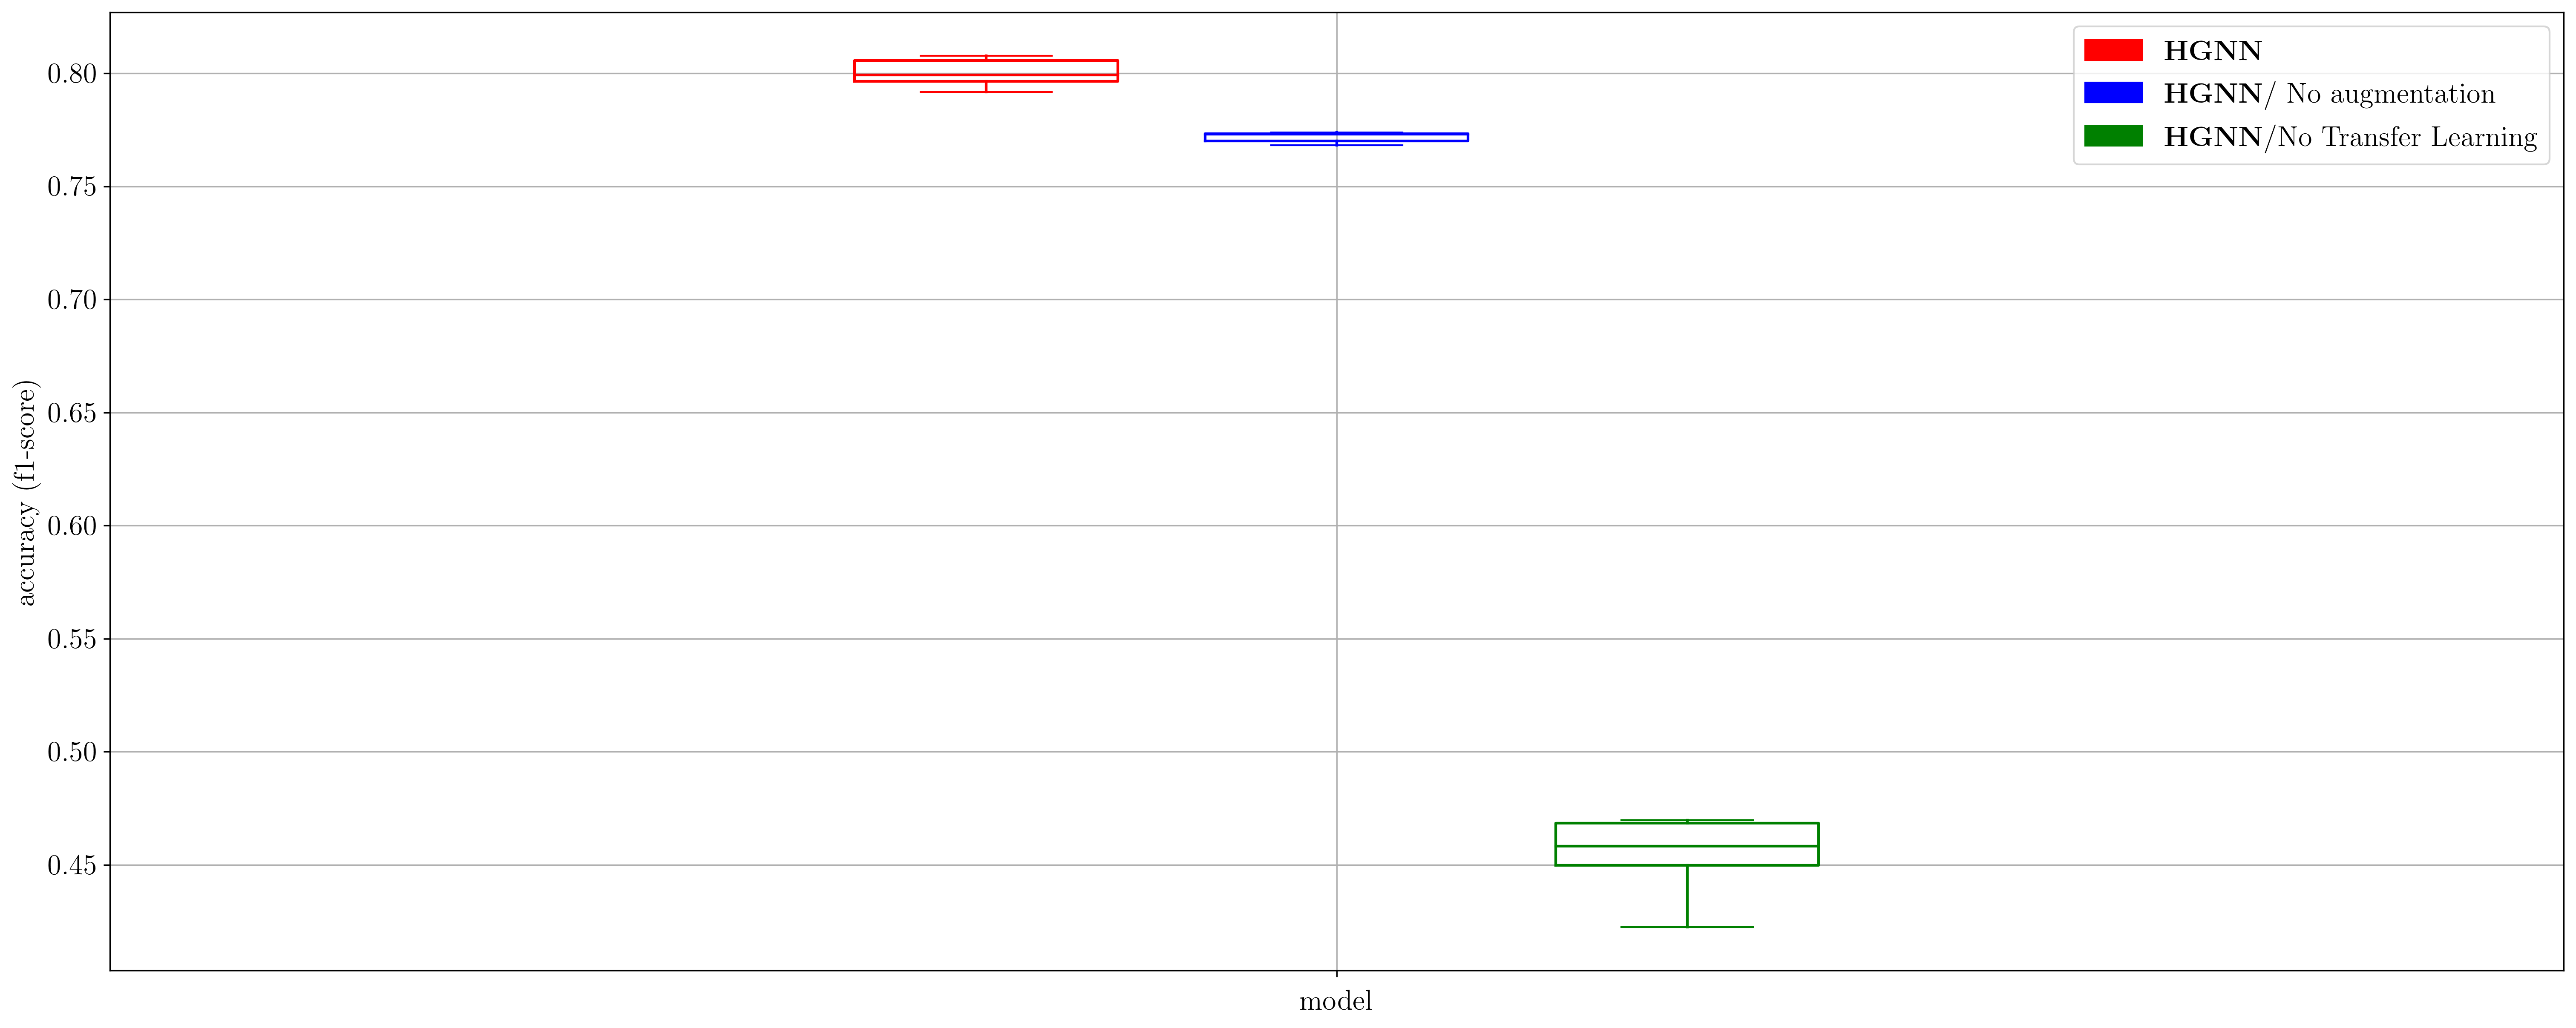

In [13]:
fig